<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week2/template_multi_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification Problem

Hey! Welcome to your next lab. Here you will implement a neural network for a multiclass classification problem.

**Requirements**
- Although it's not mandatory, we highly recommend that you complete Binary Classification Lab before working on this one.

**Instructions**
- Write code in the space indicated with `### START CODE HERE ###`
- Do not use loops (for/while) unless instructions explicitly tell you so. Parallelization in Deep Learning is key!
- If you get stuck, ask for help in Slack or DM `@DRU Team`

**You will learn**
- How to implement a Neural Network for multiclass classification
    - How to balance the loss for more optimal training
    - How to evaluate the model with imbalanced classes
    - How to train and test a multiclass classification Neural Network


# 0 - Download data

In [2]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/2_pytorch/multi_class_classification/template.zip')
!unzip -q 'template.zip'

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e9c26ecf9faaf481643982860509bdf24ef4ddb687cff1faec89db0b4f388da2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


# 1 - Import packages and set up the environment

Here we will import a regular set of packages with a few additional ones.

- [pandas](https://pandas.pydata.org/docs/index.html) is one of the most popular Python packages for tabular data
- [seaborn](https://seaborn.pydata.org/) a package built on `matplotlib`, which provides some useful high-level functionality for graphing

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim

%matplotlib inline

## Configs

Here is our regular Config class. We define few constants like `num_classes` and `input_dim` to simplify building the network architecture.<br>
**Please note** that `classes` is a `tuple`, not a `list`, because we are not going to modify this variable anywhere in our code.

In [4]:
# VALIDATION_FIELD[cls] Config

class Config:
    # data
    test_size = 0.33
    classes = ('Mammal', 'Bird', 'Reptile',
            'Fish', 'Amphibian', 'Bug', 'Invertebrate')
    # model
    num_classes = 7
    input_dim = 16
    hidden_dims = (64, 32)

    # training
    seed = 21
    batch_size = 8
    epochs = 10
    learning_rate = 0.01
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# 2 - Data Preprocessing and visualizations

For this lab, we will learn how to classify an animal using 16 categorical features from  [Zoo Animal UCI Machine Learning Dataset](
https://www.kaggle.com/uciml/zoo-animal-classification). Here is the description of each feature in the dataset:

- animal_name: Unique for each instance
- hair Boolean
- feathers Boolean
- eggs Boolean
- milk Boolean
- airborne Boolean
- aquatic Boolean
- predator Boolean
- toothed Boolean
- backbone Boolean
- breathes Boolean
- venomous Boolean
- fins Boolean
- legs Numeric (set of values: {0,2,4,5,6,8})
- tail Boolean
- domestic Boolean
- catsize Boolean
- class_type Numeric (integer values in range [1,7])

Most of the columns in the dataset are of Boolean type, which means that they contain either 1 (meaning that an animal has the corresponding feature) or 0 (if an animal doesn't have the indicated feature). The exception is `legs,` which is a number from a set `{0,2,4,5,6,8}` representing the number of legs, and `class_type`, which has an integer value from `[1, 7]` range, representing an animal class. <br>

We will use all features (except for `animal_name`) to predict the `class_type` of the given animal.

## Load the data

**Important:** by default CrossEntropyLoss for PyTorch expects target labels to be from a range `[0, num_classes-1]`. So, we subtract 1 from `class_type`column below. Also, we use `startify` parameter in `train_test_split` to ensure that `train` and `test` sets have an equal proportion of classes.

In [7]:
def load_data(test_size=Config.test_size, seed=Config.seed):
    # read dataset from csv file
    dataset = pd.read_csv('zoo_dataset.csv')

    # drop values that we won't be using fro training
    inputs = dataset.drop(['animal_name','class_type'], axis=1).values
    # enumerate targets from 0
    targets = dataset['class_type'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(
        inputs, targets, stratify=targets,
        test_size=test_size, random_state=seed)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

In [8]:
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (143, 16) (143,)
Test set: (71, 16) (71,)


**Expected Output:**
<table>
    <tr>
        <td><b>Train set: </b></td>
        <td>(143, 16) (143,)</td>
    </tr>
    <tr>
        <td><b>Test set:</b></td>
        <td>(71, 16) (71,)</td>
    </tr>
</table>

## Data Visualization

Our target labels are the following:
* 1 - Mammal
* 2 - Bird
* 3 - Reptile
* 4 - Fish
* 5 - Amphibian
* 6 - Bug
* 7 - Invertebrate

Let's visualize how many representatives of each class we have

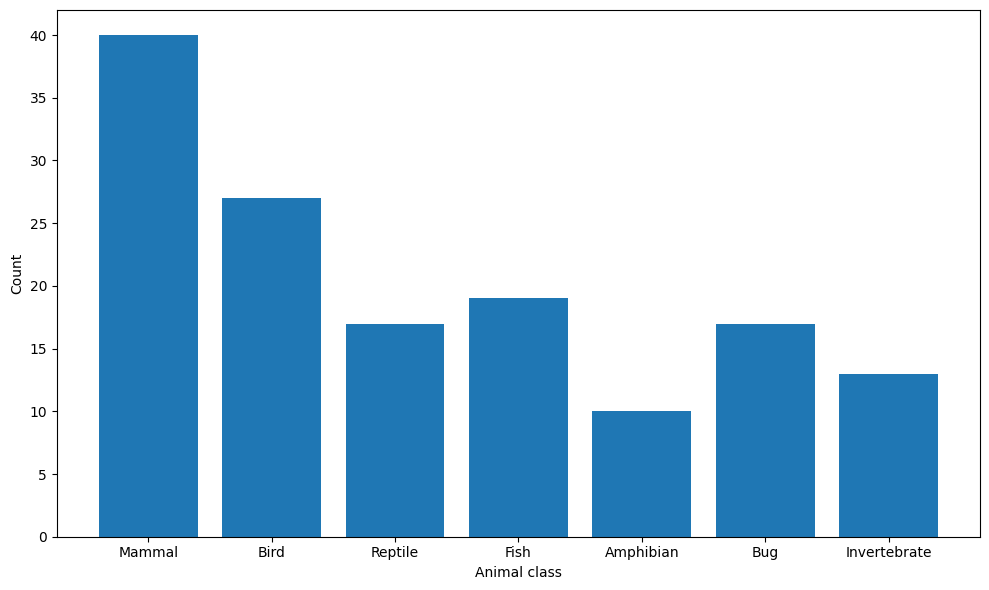

In [9]:
plt.figure(figsize=(10, 6))
class_counts = pd.value_counts(y_train)
plt.bar(class_counts.index, class_counts.to_list())
plt.xticks(np.arange(Config.num_classes), Config.classes)
plt.ylabel('Count')
plt.xlabel('Animal class')
plt.tight_layout()
plt.show()

**Interpretation:** As we can see from the graph above, our classes are unbalanced, meaning that some classes like **Mammal** have much more examples in the dataset than **Bug** or **Amphibian**. This might lead to poor model performance because the neural network will prioritize correctly predicting classes that are more abundant in the dataset and neglect the others.

# 3 - Utils

## Loss Scaler

In the standard variation of multiclass classification, we use Cross Entropy between network predictions and target values, which is given by the formula below:

$$CE(y, \hat{y}) = - \sum^{{n}_{c}-1}_{i=0} y_{i}\log(\hat{y}_{i})$$

where $y\in\mathbb{R}^{n_c}$ is a one-hot label vector, $\hat{y}\in\mathbb{R}^{n_c}$ is network predictions, and ${n}_{c}$ is the number of classes. <br>
And to find the overall loss over a batch we simply average the cross entropy for each of the network prediction:

$$CELoss(Y, \hat{Y}) = - \frac{1}{m}\sum^{{m}-1}_{j=0} \sum^{{n}_{c}-1}_{i=0} y_{i}^{<j>}\log(\hat{y}_{i}^{<j>})$$

Note here, $Y\in\mathbb{R}^{m\ x\ n_c}$ and $\hat{Y}\in\mathbb{R}^{m\ x\ n_c}$ are matrices of network predictions and target values respectfully, where $m$ is a number of examples in a batch, and $y_{i}^{<j>}$ is a prediction for the ith class of the jth example in the batch. <br>

A simple average over all training examples, in this case, is not the best strategy. Instead of learning distinct features of each class, a neural network will learn how to correctly classify the most popular classes in the dataset, which would minimize the average value, ignoring the classes that rarely occur in the mini-batch. For example,  **Mammal** class, which has 40 examples, would be prioritized over **Amphibian** class, which has only 10 examples in the dataset. <br><br>

So, instead of taking a **simple average** over all training examples, we will take a **weighted average**, increasing the importance of rare classes, and penalizing classes that occur much more often. The formulas, for the class weights are given below:


$$score_i = \sqrt{\frac{\sum_{i=0}^{n\_classes-1}m_i}{m_i}}$$ <br>
$$w_i = \frac{score_i}{\sum_{i=0}^{n\_classes-1}score_i}$$

where $m_i$ is a number of representatives of class $i$ in the dataset, $score_i$ is relative importance of each class, and $w_i$ is a normalized weight that ensures that the sum of our weights adds up to 1. <br>

**Excercise:** Your job is to implement `get_loss_scalars` function that calculates weights `w_i` to scale `CrossEntropyLoss`

In [20]:
# VALIDATION_FIELD[func] get_loss_scalars

def get_loss_scalars(labels):
    """
    Calculates the coefficients that scale the importance of rare classes
    in CrossEntropyLoss

    The formula for calculation is:
    score_i = (total_number_of_samples / number_samples_of_label_i)^1/2
    weight_i = score_i/sum_scores

    Arguments:
    labels -- 1-D np.array of integers that represents classes in the dataset
    Return:
    weights -- 1-D torch.Tensor of length num_classes
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    counts = np.bincount(labels)
    #print(counts)
    scores = np.sqrt(len(labels) / counts)
    #print(scores)
    weights = torch.tensor(scores / np.sum(scores), dtype=torch.float)
    ### END CODE HERE ###
    return weights

In [21]:
weights = get_loss_scalars(y_train)
print('weights:', weights)

weights: tensor([0.0953, 0.1160, 0.1462, 0.1383, 0.1907, 0.1462, 0.1672])


**Expected output:**

<table>
    <tr>
        <td><b>weights</b></td>
        <td>tensor([0.0953, 0.1160, 0.1462, 0.1383, 0.1907, 0.1462, 0.1672])</td>
    </tr>

</table>

## F1 score

Besides the loss function that we use for training, we need to have a metric to account for class imbalances.
Accuracy score would simply tell us what proportion of all examples we classify correctly, but it doesn't tell us how
well we perform on underrepresented classes. The following metric, called **F1 score** does just that. For a given
class $i$ we calculate **F1 score** using:

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/confusion.png">

* $TP$ (true positive) = number of correct predictions of class $i$
* $FP$ (false positive) = number of false predictions of class $i$
* $FN$ (false negative) = number of examples of class $i$ not predicted with class $i$

$$ Precision = \frac{TP}{FP + TP} $$ <br>
$$ Recall = \frac{TP}{FN + TP} $$ <br>

$$ F1_i = \frac{ 2 * Precision * Recall}{Precision + Recall} $$

And then, to calculate **macro F1 score**, we simply average all $F1_i$

$$ F1_{macro} = \sum^{{n}_{c}-1}_{i=0} F1_i $$

**Note:** This function is available in `sklearn.metrics` but we will implement it to understand this evaluation method better.

**Excercise:** Implement the F1 scoring function using the formulas above. You will have to use for-loop to iterate over unique target labels.
- Hint: if for a given class $TP = 0$, you should assign $F1_i = 0$

In [52]:
# VALIDATION_FIELD[func] f1_score

def f1_score(target, predictions):
    """
    Calculates macro f1 score for target and predictions

    Arguments:
    target -- 1-D torch.Tensor of target classes
    predictions -- 1-D torch.Tensor of integer network predictions

    Returns:
    F1_macro -- float, macro avergae of F1 scores
    """
    scores = []
    for cls in target.unique():
        ### START CODE HERE ### (≈ 9 lines of code)
        TP = ((target == cls) & (predictions == cls)).sum().item()
        FN = ((target == cls) & (predictions != cls)).sum().item()
        FP = ((target != cls) & (predictions == cls)).sum().item()
        if TP == 0:
            F1 = 0
        else:
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)
            F1 = 2 * (precision * recall) / (precision + recall)
        ### END CODE HERE ###
        scores.append(F1)
    F1_macro = sum(scores) / len(scores)
    return F1_macro

In [53]:
target = torch.tensor([0, 1, 2, 3, 1, 4])
predic = torch.tensor([0, 1, 2, 0, 1, 2])
print('f1_score:', f1_score(target, predic))

f1_score: 0.4666666666666666


**Expected output:**

<table>
    <tr>
        <td><b>f1_score</b></td>
        <td>0.4666666666666666</td>
    </tr>

</table>

# 3 - Creating the model class

In the last lab, we learned how to use `nn.Sequential` to predefine the order of operations for some layers in the network. This time we will go even further and define our sequential blocks iteratively using `nn.ModuleList`<br>

Let's start with a simple function that returns our usual Sequential block <br>

**Excercise:** Implement function that returns `nn.Sequential` module with the following layers: `nn.Linear` -> `nn.Dropout` -> `nn.ReLU`
- Set parameter `p` in Dropout to `0.2`

In [54]:
# VALIDATION_FIELD[func] linear_block

def linear_block(input_dim, output_dim):
    """
    Generates a generic sequential block

    Arguments:
    input_dim -- integer, input dimension to a linear block
    output_dim -- integer, output dimension of a linear block

    Return:
    block -- nn.Sequential, block of a neural network
    """
    ### START CODE HERE ### (≈ 4 lines of code)
    block = nn.Sequential(nn.Linear(input_dim, output_dim),
                          nn.Dropout(p=0.2),
                          nn.ReLU())
    ### END CODE HERE ###
    return block

## Model

The architecture of this network is very similar to the binary classification network, with a few exceptions:
1. The output layer of this network has seven neurons (one for each class)
2. The output layer has linear activation (no activation function is applied). This is because we will use `nn.CrossEntropyLoss` as our loss function that expects raw logits as an output from the neural network.

<img src="https://dru.fra1.digitaloceanspaces.com/DL_pytorch/static/ntbk_images/multiclass_cls_network.png">

**Excercise:** Implement `__init__` and `__forward__` for a Multiclass Classification Neural Network. <br>
- In `__init__`, define a `nn.ModuleList` with the name `block_list`, which would contain all but the last layer of the neural network.
- **Important:** your implementation of `__init__` should be universal for any number of input `hidden_dims`. In other words, don't use direct indexing `hidden_dims[0]`, `hidden_dims[1]`, because parameter `hidden_dims` might have more than two elements!
- Also, define the last linear layer `out`
    - Do not use any activation function for the last layer
    - Do not wrap Linear layer in `nn.Sequential`
- In `forward()`, simply pass your input x through all of the layers defined above.
    - Don't forget to pass your input through every block in `block_list`!

In [56]:
# VALIDATION_FIELD[cls] NNet

class NNet(nn.Module):
    def __init__(self,
                 input_dim=Config.input_dim,
                 num_classes=Config.num_classes,
                 hidden_dims=Config.hidden_dims):
        super(NNet, self).__init__()
        dims = [input_dim] + list(hidden_dims)
        ### START CODE HERE ### (≈ 2 lines of code)
        self.block_list = nn.ModuleList([linear_block(dims[i], dims[i+1]) for i in range(len(dims) - 1)])
        self.out = nn.Linear(hidden_dims[-1], num_classes)
        ### END CODE HERE ###

    def forward(self, x):
        ### START CODE HERE ### (≈ 3 lines of code)
        for block in self.block_list:
            x = block(x)
        x = self.out(x)
        ### END CODE HERE ###
        return x

In [57]:
# test for many hidden dims
model = NNet(1, 6, [2, 3, 4, 5])
input = torch.ones(4, 1)
assert (list(model(input).shape) == [4, 6])

In [58]:
# test the architecture design
print(NNet())

NNet(
  (block_list): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
    )
  )
  (out): Linear(in_features=32, out_features=7, bias=True)
)


**Expected output:**
```
NNet(
  (block_list): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=64, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): ReLU()
    )
  )
  (out): Linear(in_features=32, out_features=7, bias=True)
)
```

# 4 - Training the model

**Excercise:** implement training loop for the model. <br>
**Please note** that in the previous lab where we calculated accuracy for each batch and then averaged the values; here, we will collect all of the network predictions first and then calculate the f1 score. This is done because F1-score is largely influenced by a sample of target labels, so it's much more stable to run evaluation once we know all of the predictions.

In [ ]:
# VALIDATION_FIELD[func] train

def train(model, optimizer, criterion, X_train, y_train,
          num_epochs=Config.epochs,
          batch_size=Config.batch_size,
          device=Config.device):
    loss_values, f1_values = [], []
    for e in range(num_epochs):
        epoch_loss =  0
        num_steps = 0
        network_predictions = []
        for i in range(0, X_train.shape[0], batch_size):
            ### START CODE HERE ###
            # data prep (≈ 4 lines of code)
            x_batch =         # Load batch_size of samples from X_train
            y_batch =         # Load batch_size of corresponding target values from y_train
            x_tensor =        # Create torch.FloatTensor from x_batch and pass it to device
            y_tensor =        # Create torch.LongTensor from y_batch and pass it to device
            # forward (≈ 2 lines of code)
            out =             # Pass x_batch forward through the model
            loss =            # Calculate the loss using criterion
            # optimization (≈ 3 lines of code)

            # calculate network predictions (≈ 1 line of code)
            labels =
            ### END CODE HERE ###
            network_predictions.extend(labels)
            epoch_loss += loss.item()
            num_steps += 1
        targets = torch.tensor(y_train)
        preds = torch.tensor(network_predictions)
        f1 = f1_score(targets, preds)
        epoch_loss /= num_steps
        loss_values.append(epoch_loss)
        f1_values.append(f1)
        print(f'EPOCH: {e+1} \tF-1: {f1:.3f}\tLOSS: {epoch_loss:.3f}')
    return loss_values, f1_values

In [ ]:
set_seed(Config.seed)
net = NNet().to(Config.device)
optimizer = optim.Adam(net.parameters(), lr=Config.learning_rate)
weighted_criterion = nn.CrossEntropyLoss(weight=get_loss_scalars(y_train)).to(Config.device)
loss, f1 = train(net, optimizer, weighted_criterion, X_train, y_train)

**Expected Output:**

```
EPOCH: 1 	F-1: 0.353	LOSS: 1.729
EPOCH: 2 	F-1: 0.559	LOSS: 0.920
EPOCH: 3 	F-1: 0.756	LOSS: 0.549
EPOCH: 4 	F-1: 0.811	LOSS: 0.419
EPOCH: 5 	F-1: 0.871	LOSS: 0.258
...
```

In [ ]:
fig, ax =  plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(loss)
ax[0].set_title('Training Loss')
ax[1].plot(f1)
ax[1].set_title('Training F1-score')
plt.tight_layout()
plt.show()

As we can see training loss is still decreasing, meaning that we can achieve even better results on the train set if we would continue to train our model. However, there is always a danger of overfitting, so we should check our performance on the test set.

# 5 - Evaluating the model
**Excercise:** Implement evaluation loop for our model

In [ ]:
# VALIDATION_FIELD[func] evaluate

def evaluate(model, criterion, X_test, y_test,
             batch_size=Config.batch_size, class_names=Config.classes, device=Config.device):
    model.eval()
    with torch.no_grad():
        network_predictions = []
        overall_loss = 0
        num_steps = 0
        for i in range(0, X_test.shape[0], batch_size):
            ### START CODE HERE ### (≈7 lines of code)
            x_batch =
            y_batch =
            x_tensor =
            y_tensor =
            out =
            loss =
            labels =
            ### END CODE HERE ###
            num_steps += 1
            overall_loss += loss.item()
            network_predictions.extend(labels)

    # calculate metrics
    overall_loss /= num_steps
    targets = torch.tensor(y_test)
    preds = torch.tensor(network_predictions)
    f1 = f1_score(targets, preds)
    return {
        'targets':targets,
        'predictions': preds,
        'loss': overall_loss,
        'f1_macro': f1
    }

In [ ]:
results = evaluate(net, weighted_criterion, X_test, y_test)
print('Test Loss:', results['loss'])
print('Test F1 Macro:', results['f1_macro'])

**Expected output:**

<table>
    <tr>
        <td><b>Test Loss</b></td>
        <td>0.1952717396327191</td>
    </tr>
    <tr>
        <td><b>Test F1 Macro</b></td>
        <td>0.921401489070662</td>
    </tr>

</table>

In [ ]:
confusion = confusion_matrix(results['targets'], results['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cbar=False,
            xticklabels=Config.classes,
            yticklabels=Config.classes)
plt.ylabel('Predicted class')
plt.xlabel('Actual class')
plt.show()

**Interpretation:** As we can see from the confusion matrix, our model performs decently well on most examples. It confuses only some amphibians with reptiles and some bugs with invertebrates, which is justifiable given that those animal classes have similar characteristics.

# 6 - What to do next

After you submit your lab, try playing with model architecture, and hyperparameters. We highly recommend that you try fitting a model without loss scaling and compare the results.